170508288/170498071 [==============================] - 3s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
125/125 [==============================] - 77s 326ms/step - loss: 1.8820 - accuracy: 0.3162 - val_loss: 2.1593 - val_accuracy: 0.2930
Epoch 2/50
125/125 [==============================] - 39s 309ms/step - loss: 1.5222 - accuracy: 0.4401 - val_loss: 1.5085 - val_accuracy: 0.4475
Epoch 3/50
125/125 [==============================] - 39s 308ms/step - loss: 1.3511 - accuracy: 0.5157 - val_loss: 2.0773 - val_accuracy: 0.4115
Epoch 4/50
125/125 [==============================] - 39s 308ms/step - loss: 1.2324 - accuracy: 0.5610 - val_loss: 1.3136 - val_accuracy: 0.5335
Epoch 5/50
125/125 [==============================] - 39s 308ms/step - loss: 1.1116 - accuracy: 0.5994 - val_loss: 1.6816 - val_accuracy: 0.4880
Epoch 6/50
125/125 [==============================] - 39s 308ms/step - loss: 1.0284 - accuracy: 0.6386 - val_loss: 1.2068 - val_accuracy: 0.5785
Epoch 7/50
125/125 [==============================] - 40s 322ms/step - loss: 0.9685 - accuracy: 0.6538 - val_loss: 1.1088 - val_ac

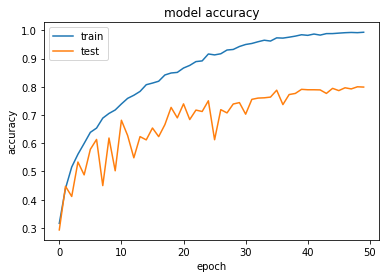

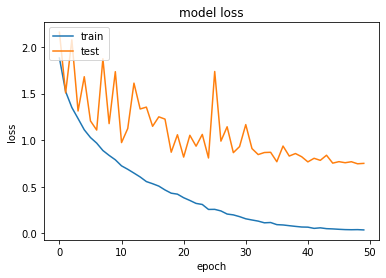

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
import numpy as np


def conv_module(input,No_of_filters,filtersizeX,filtersizeY,stride,chanDim,padding="same"):
  input = Conv2D(No_of_filters,(filtersizeX,filtersizeY),strides=stride,padding=padding)(input)
  input = BatchNormalization(axis=chanDim)(input)
  input = Activation("relu")(input)
  return input

def inception_module(input,numK1x1,numK3x3,numk5x5,numPoolProj,chanDim):
                                 #Step 1
  conv_1x1 = conv_module(input, numK1x1, 1, 1,(1, 1), chanDim) 
                                 #Step 2
  conv_3x3 = conv_module(input, numK3x3, 3, 3,(1, 1), chanDim)
  conv_5x5 = conv_module(input, numk5x5, 5, 5,(1, 1), chanDim)
                                 #Step 3
  pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
  pool_proj = Conv2D(numPoolProj, (1, 1), padding='same', activation='relu')(pool_proj)
                                 #Step 4
  input = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=chanDim)
  return input


def downsample_module(input,No_of_filters,chanDim):
  conv_3x3=conv_module(input,No_of_filters,3,3,(2,2),chanDim,padding="valid")
  pool = MaxPooling2D((3,3),strides=(2,2))(input)
  input = concatenate([conv_3x3,pool],axis=chanDim)
  return input


def GoogleNet(width,height,depth,classes):
  inputShape=(height,width,depth)
  chanDim=-1

  # (Step 1) Define the model input
  inputs = Input(shape=inputShape)

  # First CONV module
  x = conv_module(inputs, 96, 3, 3, (1, 1),chanDim)

  # (Step 2) Two Inception modules followed by a downsample module
  x = inception_module(x, 32, 32,32,32,chanDim)
  x = inception_module(x, 32, 48, 48,32,chanDim)
  x = downsample_module(x, 80, chanDim)
  
  # (Step 3) Five Inception modules followed by a downsample module
  x = inception_module(x, 112, 48, 32, 48,chanDim)
  x = inception_module(x, 96, 64, 32,32,chanDim)
  x = inception_module(x, 80, 80, 32,32,chanDim)
  x = inception_module(x, 48, 96, 32,32,chanDim)
  x = inception_module(x, 112, 48, 32, 48,chanDim)
  x = downsample_module(x, 96, chanDim)

  # (Step 4) Two Inception modules followed
  x = inception_module(x, 176, 160,96,96, chanDim)
  x = inception_module(x, 176, 160, 96,96,chanDim)
  
  # Global POOL and dropout
  x = AveragePooling2D((7, 7))(x)
  x = Dropout(0.5)(x)

  # (Step 5) Softmax classifier
  x = Flatten()(x)
  x = Dense(classes)(x)
  x = Activation("softmax")(x)

  # Create the model
  model = Model(inputs, x, name="googlenet")
  return model

NUM_EPOCHS = 50
INIT_LR = 5e-3
def poly_decay(epoch):
  maxEpochs = NUM_EPOCHS
  baseLR = INIT_LR
  power = 1.0
  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

((trainX, trainY), (testX, testY)) = cifar10.load_data()
testX, testY = trainX[:2000], trainY[:2000]
trainX, trainY = trainX[2000:10000], trainY[2000:10000]
trainX = trainX.astype("float")
testX = testX.astype("float")
                                # Step 1
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean
                                # Step 2
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
                                # Step 3
aug = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1, horizontal_flip=True,fill_mode="nearest")

callbacks=[LearningRateScheduler(poly_decay)]
opt = SGD(lr=INIT_LR, momentum=0.9)
model = GoogleNet(width=32, height=32, depth=3, classes=10)
                                    # Step 1
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
                                    # Step 2
history = model.fit(aug.flow(trainX, trainY, batch_size=64),validation_data=(testX, testY), steps_per_epoch=len(trainX) // 64,epochs=NUM_EPOCHS, callbacks=callbacks, verbose=1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
